In [1]:
from local_vars import root_folder

data_folder = r"n3a"
image_size = 64
batch_size = 20
input_intensity_scaling = 1 / 255.0

In [2]:
import pandas as pd
import numpy as np
import itertools
import os
import keras

from keras.models import Sequential
from keras.layers import Activation, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.utils import Sequence

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from skimage.io import imread
from skimage.transform import resize

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)
train_fullpath = os.path.join(data_fullpath, "train")
valid_fullpath = os.path.join(data_fullpath, "valid")
test_fullpath = os.path.join(data_fullpath, "test")

print("Training data folder:   {}".format(train_fullpath))
print("Validation data folder: {}".format(valid_fullpath))
print("Test data folder:       {}".format(test_fullpath))

Training data folder:   c:\Data\n3\train
Validation data folder: c:\Data\n3\valid
Test data folder:       c:\Data\n3\test


In [4]:
train_annotations_df = pd.DataFrame()

num_csv_files = 0
for file_name in os.listdir(train_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(train_fullpath, file_name)
    train_annotations_df = pd.concat([train_annotations_df, pd.read_csv(current_file_path)])

valid_annotations_df = pd.DataFrame()

for file_name in os.listdir(valid_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(valid_fullpath, file_name)
    valid_annotations_df = pd.concat([valid_annotations_df, pd.read_csv(current_file_path)])

test_annotations_df = pd.DataFrame()

for file_name in os.listdir(test_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(test_fullpath, file_name)
    test_annotations_df = pd.concat([test_annotations_df, pd.read_csv(current_file_path)])

num_test_images = test_annotations_df.shape[0]
    
print("Number of training images:   {}".format(train_annotations_df.shape[0]))
print("Number of validation images: {}".format(valid_annotations_df.shape[0]))
print("Number of test images:       {}".format(num_test_images))

Number of training images:   5604
Number of validation images: 706
Number of test images:       699


In [5]:
annot_data = train_annotations_df[:5]
print("Original annotations")
print(annot_data)

scaled_positions = pd.concat( [annot_data['x'] / annot_data['width'], annot_data['y'] / annot_data['height']], axis=1 )
scaled_positions.columns = ['x', 'y']

# scaled_positions = np.concatenate( annot_data[:,2] / annot_data[:,0], annot_data[:,3] / annot_data[:,1], axis=1)
print("\nScaled positions")
print(scaled_positions)

Original annotations
   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1     filename  width  height class  \
0           0           699            1405  n3_1458.png    512     512  F-12   
1           1           700            1406  n3_1459.png    512     512  F-12   
2           2           701            1407  n3_1460.png    512     512  F-12   
3           3           702            1408  n3_1461.png    512     512  F-12   
4           4           703            1409  n3_1462.png    512     512  F-12   

     x    y  
0  368  316  
1  368  316  
2  368  318  
3  368  318  
4  368  318  

Scaled positions
         x         y
0  0.71875  0.617188
1  0.71875  0.617188
2  0.71875  0.621094
3  0.71875  0.621094
4  0.71875  0.621094


In [6]:
class MyBatchGenerator(Sequence):
    
    def __init__(self, image_filenames, annotations_df, batch_size, image_size=256):
        self.image_filenames, self.annotations_df = image_filenames, annotations_df
        self.batch_size = batch_size
    
    def __len__(self):
        num_batches = np.ceil(len(self.image_filenames) / float(self.batch_size))
        return int(num_batches)
    
    def __getitem__(self, idx):
        from_index = idx * self.batch_size
        to_index = (idx + 1) * self.batch_size
        batch_x = self.image_filenames[from_index:to_index]
        annot_data = self.annotations_df[['width', 'height', 'x', 'y']].iloc[from_index:to_index]
        batch_y = pd.concat( [annot_data['x'] / annot_data['width'], annot_data['y'] / annot_data['height']], axis=1 )
        return np.array([
            resize(
                imread(file_name) * input_intensity_scaling,
                (image_size, image_size, 1),
                anti_aliasing=False,
                preserve_range=True,
                mode='constant') for file_name in batch_x]),  np.array(batch_y)

In [7]:
train_image_filenames = [os.path.join(train_fullpath,fn) for fn in os.listdir(train_fullpath) if fn.endswith('png')]
valid_image_filenames = [os.path.join(valid_fullpath,fn) for fn in os.listdir(valid_fullpath) if fn.endswith('png')]
test_image_filenames = [os.path.join(test_fullpath,fn) for fn in os.listdir(test_fullpath) if fn.endswith('png')]

In [8]:
train_generator = MyBatchGenerator(train_image_filenames, train_annotations_df, batch_size, image_size)
valid_generator = MyBatchGenerator(valid_image_filenames, valid_annotations_df, batch_size, image_size)

Example input image with true location

Validation locations
[[0.40625    0.63085938]
 [0.40429688 0.62890625]
 [0.40429688 0.62890625]
 [0.40039062 0.62890625]
 [0.3984375  0.62890625]]


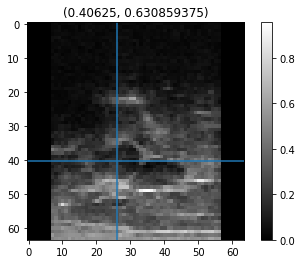

In [9]:
x, y = valid_generator.__getitem__(0)

print("Example input image with true location")
plt.title(str((y[0][0], y[0][1])))
plt.imshow(x[0][:,:,0], cmap='gray')
plt.axvline(x=y[0][0] * image_size)
plt.axhline(y=y[0][1] * image_size)
out = plt.colorbar()

print("\nValidation locations")
print(y[:5])

In [10]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
__________

In [11]:
num_validation_steps = valid_annotations_df.shape[0] // batch_size
num_steps = train_annotations_df.shape[0] // batch_size

print("Training steps:   {}".format(num_steps))
print("Validation steps: {}".format(num_validation_steps))

Training steps:   280
Validation steps: 35


In [12]:
model.compile(SGD(lr=.1), loss='mse', metrics=['accuracy'])

In [35]:
num_epochs = 8

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=num_steps,
    epochs=num_epochs,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=num_validation_steps)

Epoch 1/8
280/280 [==============================] - 31s 110ms/step - loss: 0.0011 - acc: 0.9129 - val_loss: 8.8776e-04 - val_acc: 0.9600
Epoch 2/8
280/280 [==============================] - 31s 112ms/step - loss: 0.0010 - acc: 0.9139 - val_loss: 0.0012 - val_acc: 0.9286
Epoch 3/8
280/280 [==============================] - 31s 111ms/step - loss: 0.0010 - acc: 0.9218 - val_loss: 0.0010 - val_acc: 0.9402
Epoch 4/8
280/280 [==============================] - 31s 111ms/step - loss: 9.7990e-04 - acc: 0.9239 - val_loss: 8.0634e-04 - val_acc: 0.9840
Epoch 5/8
280/280 [==============================] - 31s 111ms/step - loss: 9.1374e-04 - acc: 0.9216 - val_loss: 7.6723e-04 - val_acc: 0.9825
Epoch 6/8
280/280 [==============================] - 31s 110ms/step - loss: 9.2445e-04 - acc: 0.9234 - val_loss: 7.3897e-04 - val_acc: 0.9942
Epoch 7/8
280/280 [==============================] - 30s 109ms/step - loss: 8.8163e-04 - acc: 0.9229 - val_loss: 7.6466e-04 - val_acc: 0.9781
Epoch 8/8
280/280 [=======

Text(0.5,1,'Accuracy Curves')

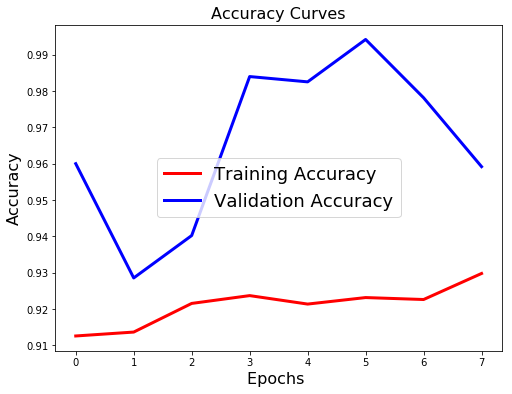

In [36]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [37]:
test_generator = MyBatchGenerator(test_image_filenames, test_annotations_df, num_test_images, image_size)

In [38]:
def plots(ims, ys, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')
        plt.axvline(x=ys[i][0] * image_size)
        plt.axhline(y=ys[i][1] * image_size)

In [39]:
x, y = test_generator.__getitem__(0)
y_pred = model.predict(x)

n = len(y)
average_error = 0.0
averaging_factor = 1.0 / n
for i in range(len(y)):
    distance = np.linalg.norm(y[i] - y_pred[i])
    average_error += distance * averaging_factor

print("Average error: {0:.4f}".format(average_error))    

print("\nTrue locations")
print(y[:5])

print("\nPredicted locations")
print(y_pred[:5])

Average error: 0.0574

True locations
[[0.58203125 0.61132812]
 [0.5859375  0.61132812]
 [0.59765625 0.609375  ]
 [0.60351562 0.609375  ]
 [0.609375   0.609375  ]]

Predicted locations
[[0.58558893 0.5888679 ]
 [0.5924262  0.5878969 ]
 [0.6212253  0.5828415 ]
 [0.6248731  0.58301157]
 [0.6407845  0.57866037]]


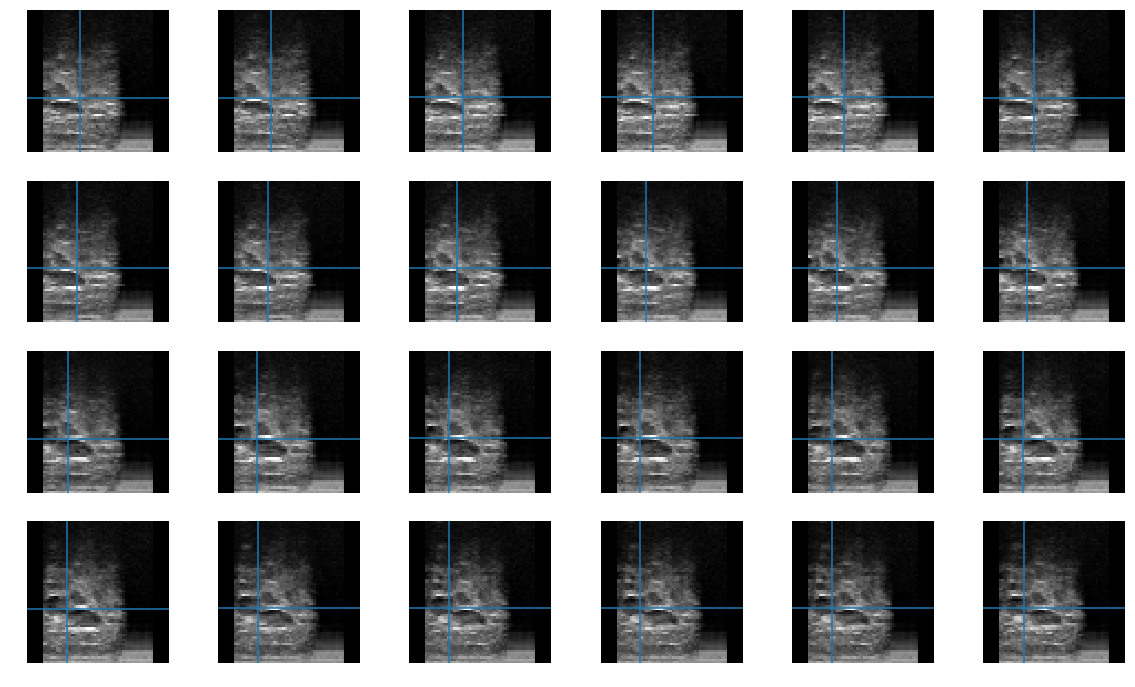

In [40]:
plots(x[300:324], y_pred[300:324], figsize=(20,12), rows=4)

In [41]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

weights_folder = os.path.join(root_folder, "weights")

if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    print("Creating folder: {}".format(weights_folder))

weights_file_name = "weights_" + timestamp + ".h5"
weights_file_path = os.path.join(weights_folder, weights_file_name)

model.save_weights(weights_file_path)